In [1]:
# Pandas
import pandas as pd
pd.set_option('display.max_colwidth', None)

# Plotly
import plotly.graph_objects as go

# Scikit learn
from sklearn import set_config
set_config(display='diagram')
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

# Markdown print
from IPython.display import Markdown, display

# Functions
def printmd(string):
    display(Markdown(string))

# Adult Census Income - Classification

## Table of Contents

1. [Logistic Regression](#Logistic-regression)
2. [Linear discriminant analysis](#Linear-discriminant-analysis)

In [2]:
# Read the datasets
datasets = {}
datasets_keys = ["original", "clean", "drop", "drop_bin", "drop_discr", "drop_bin_discr", "impute", "impute_bin", "impute_discr", "impute_bin_discr"]

# Read and encode
for key in datasets_keys:
    datasets[key] = {}
    datasets[key]["X_train"] = pd.read_csv(f"datasets/{key}/train.csv")
    datasets[key]["X_test"] = pd.read_csv(f"datasets/{key}/test.csv")
    
    # Save target variable as 0 / 1 codes
    datasets[key]["Y_train"] = datasets[key]["X_train"].income.astype("category").cat.codes
    datasets[key]["Y_test"] = datasets[key]["X_test"].income.astype("category").cat.codes
    
    # One Hot Encoding
    datasets[key]["X_train_ohe"] = datasets[key]["X_train"].copy().drop(columns=["income"])
    datasets[key]["X_test_ohe"] = datasets[key]["X_test"].copy().drop(columns=["income"])
    for col in datasets[key]["X_train_ohe"].select_dtypes("object").columns:
        if len(datasets[key]["X_train_ohe"][col].unique()) == 2:
            datasets[key]["X_train_ohe"][col] = datasets[key]["X_train_ohe"][col].astype("category").cat.codes
            datasets[key]["X_test_ohe"][col] = datasets[key]["X_test_ohe"][col].astype("category").cat.codes
    datasets[key]["X_train_ohe"] = pd.get_dummies(datasets[key]["X_train_ohe"])
    datasets[key]["X_test_ohe"] = pd.get_dummies(datasets[key]["X_test_ohe"])
    
    # Label Encoding
    datasets[key]["X_train_le"] = datasets[key]["X_train"].copy().drop(columns=["income"])
    datasets[key]["X_test_le"] = datasets[key]["X_test"].copy().drop(columns=["income"])
    for col in datasets[key]["X_train_le"].select_dtypes("object").columns:
        datasets[key]["X_train_le"][col] = datasets[key]["X_train_le"][col].astype("category").cat.codes
        datasets[key]["X_test_le"][col] = datasets[key]["X_test_le"][col].astype("category").cat.codes
    
    del datasets[key]["X_train"]
    del datasets[key]["X_test"]

## Logistic regression

Since our target variable is categorical with only two classes, linear regression doesn't work very well. Therefore, we can start our analysis with logistic regression; this algorithm, rather than modeling the response directly, it models the *probability* that the target variable belongs to a particular class:

$$p(X) = \frac{e^{\left(\beta_{0}+\beta_{1}X\right)}}{1+e^{\left(\beta_{0}+\beta_{1}X\right)}} = \frac{1}{1+e^{-\left(\beta_{0}+\beta_{1}X\right)}}$$

If you look closely, you can see that this model is similar to a regression model but plugged into the sigmoid function (also called logistic function). In fact, the main difference between linear regression and logistic regression is that the output of the latter will always take values between 0 and 1: when the output is higher than 0.5, class 1 will be assigned, otherwise class 0 is assigned.

Manipulating the model equation it is possible to obtain the *logit* transformation:

$$log\left(\frac{p(X)}{1-p(X)}\right) = \beta_{0}+\beta_{1}X$$

The regression coefficients are estimated maximizing a conditional ($P\left(y|X\right)$ *discriminative learning*) likelihood function (scikit learn's implementation minimizes the negative log likelihood function, which is a special function called *cross-entropy*). Of course, with multiple predictors like in our case, the model is constructed on a linear combination of coefficients and predictors $(\beta_{0}+\beta_{1}X_{1}+\beta_{2}X_{2}+...+\beta_{n}X_{n})$. (The likelihood function doesn't have a closed form, therefore an iterative process must be used.)

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



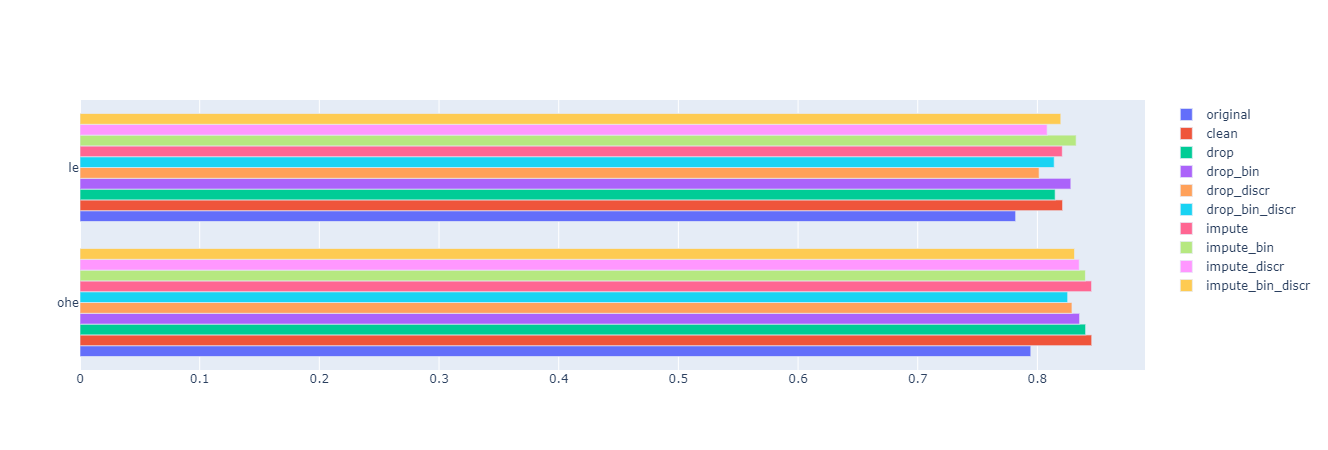

In [9]:
# Logistic Regression
logistic_regression = {}
logistic_regression_results = {}

param_grid = [
  {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs', 'saga']},
]

# Loop
for key in datasets_keys:
    logistic_regression[key] = {}
    logistic_regression_results[key] = {}
    
    # Grid search
    logistic_regression[key]["model_ohe"] = GridSearchCV(LogisticRegression(max_iter=200), param_grid, scoring='accuracy', n_jobs=10).fit(
        datasets[key]["X_train_ohe"], datasets[key]["Y_train"]
    ).best_estimator_
    logistic_regression[key]["model_le"] = GridSearchCV(LogisticRegression(max_iter=200), param_grid, scoring='accuracy', n_jobs=10).fit(
        datasets[key]["X_train_le"], datasets[key]["Y_train"]
    ).best_estimator_
    
    # Test
    logistic_regression_results[key]["ohe"] = logistic_regression[key]['model_ohe'].score(datasets[key]['X_test_ohe'], datasets[key]['Y_test'])
    logistic_regression_results[key]["le"] = logistic_regression[key]['model_le'].score(datasets[key]['X_test_le'], datasets[key]['Y_test'])

# Plot
fig = go.Figure()
logistic_regression_results = pd.DataFrame(logistic_regression_results)
for col in logistic_regression_results:
    fig.add_traces(go.Bar(y=logistic_regression_results.index, x=logistic_regression_results[col], orientation="h", name=col))

fig.show()

## Linear discriminant analysis

*Discriminant analysis* is a probabilistic model whose approach is to estimate the distribution of each feature in the dataset, and then compute the posterior probability of the target class exploiting the Bayes theorem (which makes the assumption of independent features). Therefore the predictions are made looking to the feature with the highest density. Bayes recall:

$$P\left(Y=k|X=x\right) = \frac{P\left(X=x|Y=k\right)*P\left(Y=k\right)}{P\left(X=x\right)} = \frac{\pi_{k}*f_{k}\left(x\right)}{\sum_{l=1}^{K}\pi_{l}*f_{l}\left(x\right)}$$

On the right part of the equation $f_{k}\left(x\right)$ is the *density* of $x$ when the class is $k$ and $\pi_{k}$ is the *marginal* probability of class $k$.

With multiple predictors like in our case, the model assumes that the input $X$ has a multivariate normal distribution, with distinct means and common covariance matrix; hence, the discriminant function has the form:

$$\delta_{k}\left(x\right) = x^{T}\Sigma^{-1}\mu_{k}-\frac{1}{2}\mu_{k}^{T}\Sigma^{-1}\mu_{k}+log\left(\pi_{k}\right)$$

To an observation $x$ will be assigned the class with the largest *discriminant score*:

$$\delta_{k}\left(x\right) = x*\frac{\mu_{k}}{\sigma^{2}} - \frac{\mu_{k}^{2}}{2\sigma^{2}} + log\left(\pi_{k}\right)$$

Linear discriminant analysis parameters are estimated using the full likelihood function ($P\left(X,y\right)$ *generative learning*).

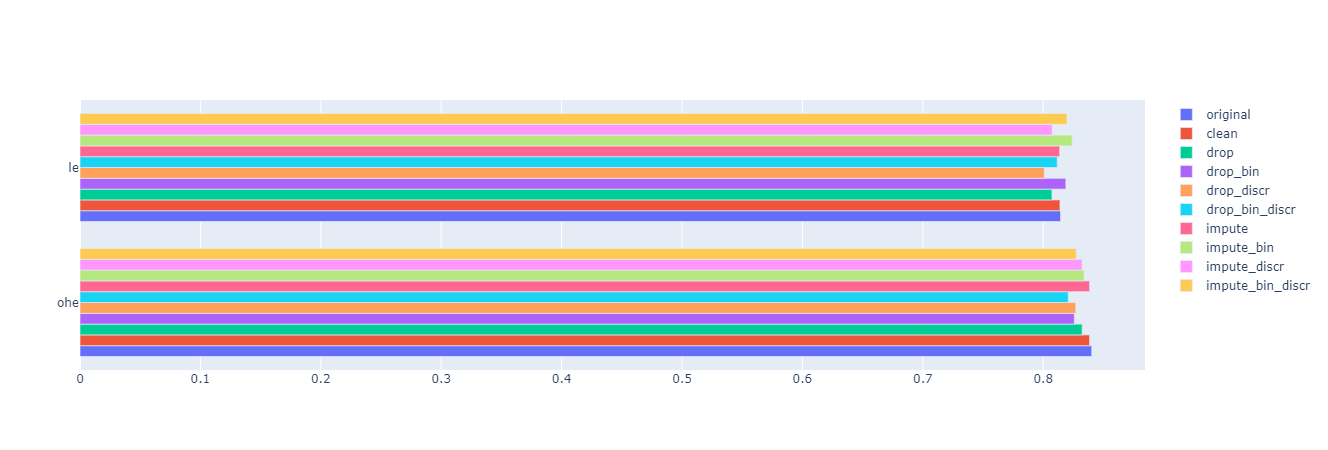

In [10]:
# Linear Discriminant Analysis
lda = {}
lda_results = {}

param_grid = [
  {'solver': ['svd', 'lsqr', 'eigen']},
]

# Loop
for key in datasets_keys:
    lda[key] = {}
    lda_results[key] = {}
    
    # Grid search
    lda[key]["model_ohe"] = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, scoring='accuracy', n_jobs=8).fit(
        datasets[key]["X_train_ohe"], datasets[key]["Y_train"]
    ).best_estimator_
    lda[key]["model_le"] = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, scoring='accuracy', n_jobs=8).fit(
        datasets[key]["X_train_le"], datasets[key]["Y_train"]
    ).best_estimator_
    
    # Test
    lda_results[key]["ohe"] = lda[key]['model_ohe'].score(datasets[key]['X_test_ohe'], datasets[key]['Y_test'])
    lda_results[key]["le"] = lda[key]['model_le'].score(datasets[key]['X_test_le'], datasets[key]['Y_test'])

# Plot
fig = go.Figure()
lda_results = pd.DataFrame(lda_results)
for col in lda_results:
    fig.add_traces(go.Bar(y=lda_results.index, x=lda_results[col], orientation="h", name=col))

fig.show()

## K-Nearest Neighbors

KNN is a non-parametric model that exploits the available data to make predictions; specifically, after having defined a proper distance measure, the model looks at the $K$ *nearest* points and then assigns the class by majority voting. The main drawback of this model, apart from the infering slowness, is that highdimensional space is empty, therefore, with a lot of variables like in our case, we cannot expect the model to perform very well.

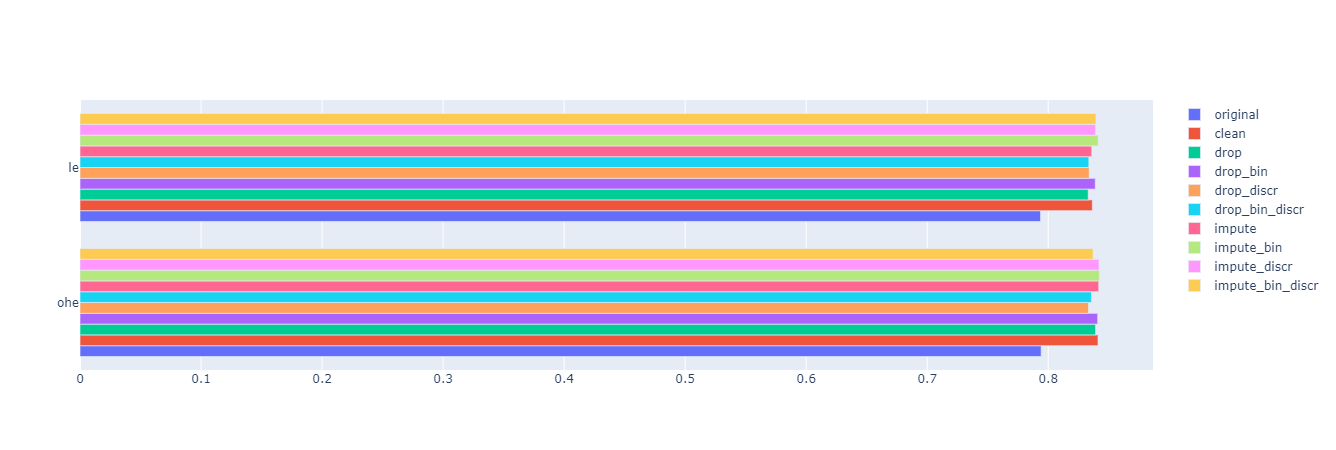

In [11]:
# KNN
knn = {}
knn_results = {}

param_grid = [
  {'n_neighbors': [2, 3, 5, 7, 9, 13, 17, 20]},
]

# Loop
for key in datasets_keys:
    knn[key] = {}
    knn_results[key] = {}
    
    # Grid search
    knn[key]["model_ohe"] = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy', n_jobs=8).fit(
        datasets[key]["X_train_ohe"], datasets[key]["Y_train"]
    ).best_estimator_
    knn[key]["model_le"] = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy', n_jobs=8).fit(
        datasets[key]["X_train_le"], datasets[key]["Y_train"]
    ).best_estimator_
    
    # Test
    knn_results[key]["ohe"] = knn[key]['model_ohe'].score(datasets[key]['X_test_ohe'], datasets[key]['Y_test'])
    knn_results[key]["le"] = knn[key]['model_le'].score(datasets[key]['X_test_le'], datasets[key]['Y_test'])

# Plot
fig = go.Figure()
knn_results = pd.DataFrame(knn_results)
for col in knn_results:
    fig.add_traces(go.Bar(y=knn_results.index, x=knn_results[col], orientation="h", name=col))

fig.show()

## Decision trees

Decision tree models stratify the predictor space into simpler regions in order to make predictions. The assigned class is simply the most probable inside that region.

The most difficult part is therefore the definition of the tree and the *split criterions*. The main idea behind the definition of a *split criterion* is to generate splits where there is a low *mixing* of class variables. Hence, we need to define a measure for this *mixing* and then generate all the splits recursively.

Of course, the model stops when the level of *mixing* inside a branch is below a given threshold.

The two most common measures of impurity are:

- Gini index: $G=\sum\limits_{k=1}^{K}\hat{p}_{mk}\left(1-\hat{p}_{mk}\right)$ which is a measure of total variance across the $K$ classes
- Cross-entropy: $D=-\sum\limits_{k=1}^{K}\hat{p}_{mk}log\left(\hat{p}_{mk}\right)$

### Pros

- Simple and interpretable
- Almost no need of data preparation (can handle categorical variables)

### Cons

- Can overfit pretty easily
- Not very accurate with respect to other supervised models (however, despite decreasing the interpretability, aggregating trees can solve this problem)
- Affected by unbalanced target classes

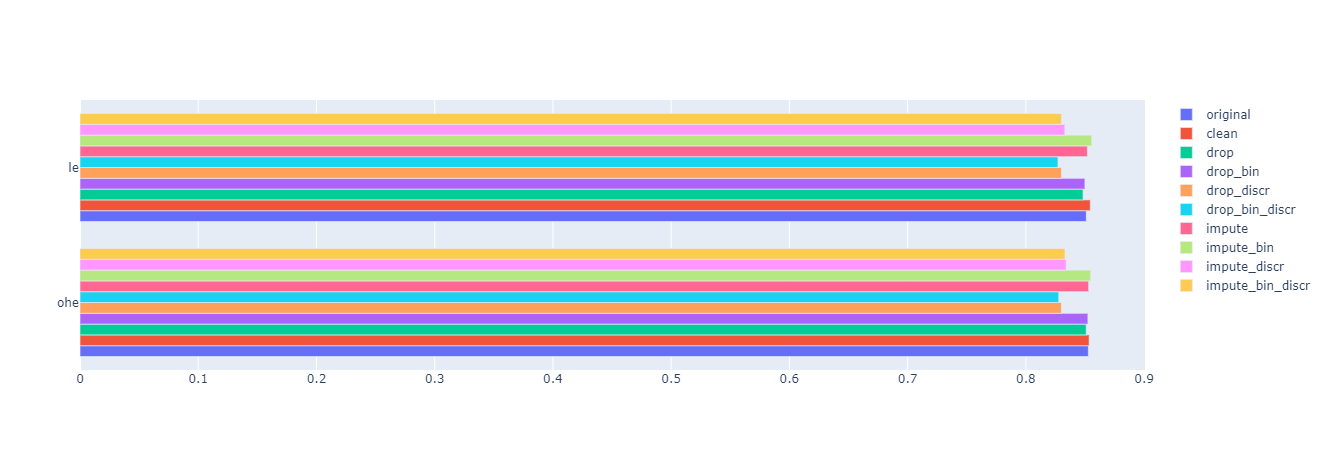

In [13]:
# Decision trees
dt = {}
dt_results = {}

param_grid = [
  {'criterion': ['gini', 'entropy'], 'max_depth': [4, 8, 12]},
]

# Loop
for key in datasets_keys:
    dt[key] = {}
    dt_results[key] = {}
    
    # Grid search
    dt[key]["model_ohe"] = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='accuracy', n_jobs=8).fit(
        datasets[key]["X_train_ohe"], datasets[key]["Y_train"]
    ).best_estimator_
    dt[key]["model_le"] = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='accuracy', n_jobs=8).fit(
        datasets[key]["X_train_le"], datasets[key]["Y_train"]
    ).best_estimator_
    
    # Test
    dt_results[key]["ohe"] = dt[key]['model_ohe'].score(datasets[key]['X_test_ohe'], datasets[key]['Y_test'])
    dt_results[key]["le"] = dt[key]['model_le'].score(datasets[key]['X_test_le'], datasets[key]['Y_test'])

# Plot
fig = go.Figure()
dt_results = pd.DataFrame(dt_results)
for col in dt_results:
    fig.add_traces(go.Bar(y=dt_results.index, x=dt_results[col], orientation="h", name=col))

fig.show()

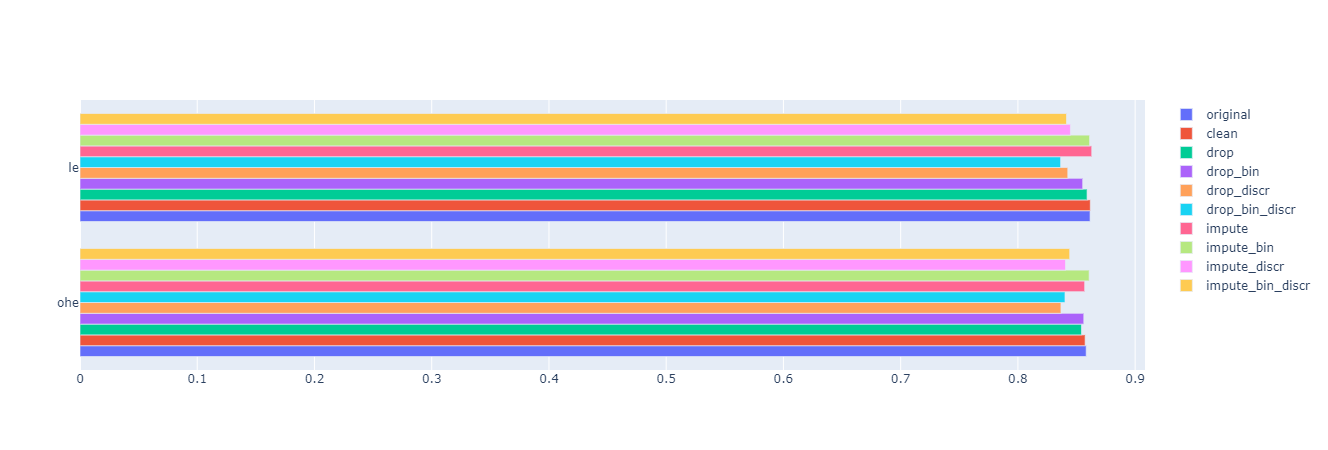

In [15]:
# Random forest
rf = {}
rf_results = {}

param_grid = [
  {'n_estimators': [50, 100, 150], 'criterion': ['gini', 'entropy'], 'max_depth': [4, 8, 12]},
]

# Loop
for key in datasets_keys:
    rf[key] = {}
    rf_results[key] = {}
    
    # Grid search
    rf[key]["model_ohe"] = GridSearchCV(RandomForestClassifier(), param_grid, scoring='accuracy', n_jobs=8).fit(
        datasets[key]["X_train_ohe"], datasets[key]["Y_train"]
    ).best_estimator_
    rf[key]["model_le"] = GridSearchCV(RandomForestClassifier(), param_grid, scoring='accuracy', n_jobs=8).fit(
        datasets[key]["X_train_le"], datasets[key]["Y_train"]
    ).best_estimator_
    
    # Test
    rf_results[key]["ohe"] = rf[key]['model_ohe'].score(datasets[key]['X_test_ohe'], datasets[key]['Y_test'])
    rf_results[key]["le"] = rf[key]['model_le'].score(datasets[key]['X_test_le'], datasets[key]['Y_test'])

# Plot
fig = go.Figure()
rf_results = pd.DataFrame(rf_results)
for col in rf_results:
    fig.add_traces(go.Bar(y=rf_results.index, x=rf_results[col], orientation="h", name=col))

fig.show()

## Support vector machines

Support vector machines generate hyperplanes that separate data depending on the target class. Of course, data is not always perfectly separable, hence the definition of separation is softened.

The general equation of an hyperplane is:

$$\beta_{0} + \beta_{1}X_{1} + \beta_{2}X_{2} + ... + \beta_{p}X_{p} = 0$$

The parameters are computed finding the hyperplane that generates the largest margin between the two classes. Since the data is not always separable, a parameter $C$ is introduced to allow some points to fall inside the margin. If we need a non-linear hyperplane, it is possible to expand the feature space using polynomial functions or kernels.

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



original


c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



clean


c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



drop


c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



drop_bin


c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



drop_discr


c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



drop_bin_discr


c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



impute


c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



impute_bin


c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



impute_discr


c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



impute_bin_discr


c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning:

Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



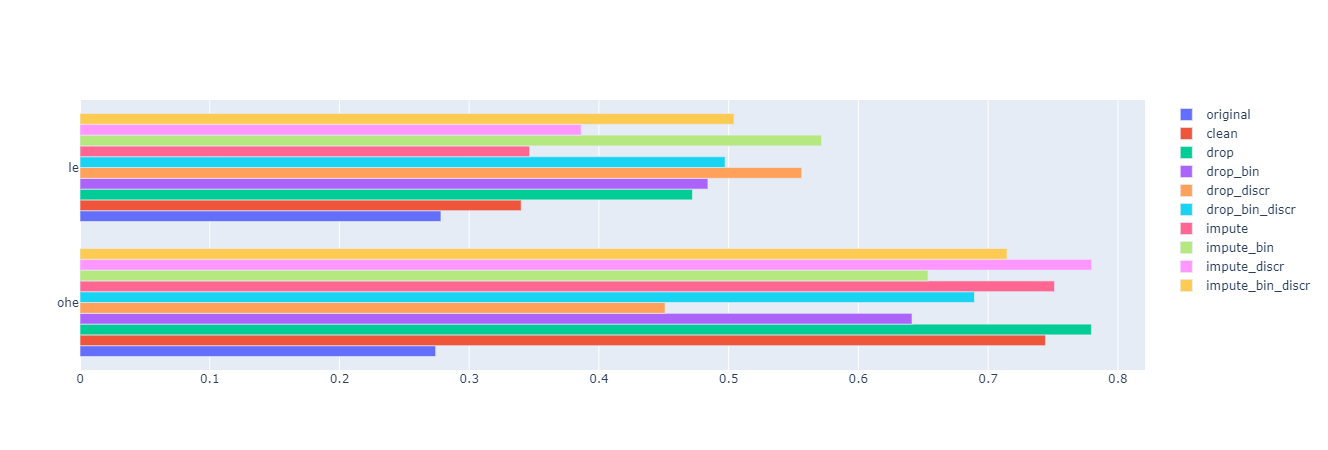

In [18]:
# Support vector machines
svm = {}
svm_results = {}

param_grid = [
  {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
]

# Loop
for key in datasets_keys:
    svm[key] = {}
    svm_results[key] = {}
    
    # Grid search
    svm[key]["model_ohe"] = GridSearchCV(SVC(cache_size=3000, max_iter=200), param_grid, scoring='accuracy', n_jobs=8).fit(
        datasets[key]["X_train_ohe"], datasets[key]["Y_train"]
    ).best_estimator_
    svm[key]["model_le"] = GridSearchCV(SVC(cache_size=3000, max_iter=200), param_grid, scoring='accuracy', n_jobs=8).fit(
        datasets[key]["X_train_le"], datasets[key]["Y_train"]
    ).best_estimator_
    
    # Test
    svm_results[key]["ohe"] = svm[key]['model_ohe'].score(datasets[key]['X_test_ohe'], datasets[key]['Y_test'])
    svm_results[key]["le"] = svm[key]['model_le'].score(datasets[key]['X_test_le'], datasets[key]['Y_test'])
    print(key)

# Plot
fig = go.Figure()
svm_results = pd.DataFrame(svm_results)
for col in svm_results:
    fig.add_traces(go.Bar(y=svm_results.index, x=svm_results[col], orientation="h", name=col))

fig.show()

0.7483110183024199

In [12]:
datasets["drop_discr"]["X_train_ohe"]

,age,education,sex,capital,work_hours,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,country_Portugal,country_Puerto-Rico,country_Scotland,country_South,country_Taiwan,country_Thailand,country_Trinadad&Tobago,country_United-States,country_Vietnam,country_Yugoslavia
0,-1.032593,-0.438162,1,-0.101855,0.051358,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.190127,1.131746,1,-0.101855,0.051358,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.449220,-0.438162,0,-0.101855,0.051358,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,-0.291686,-0.438162,0,-0.101855,-2.369463,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,-0.291686,-0.438162,1,-0.101855,0.051358,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22589,0.449220,0.739269,1,-0.101855,0.051358,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
22590,-1.032593,0.346792,0,-0.101855,0.051358,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
22591,-1.032593,-0.438162,1,-2.864528,0.051358,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
22592,-1.032593,0.739269,1,-0.101855,0.051358,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
import numpy as np
from scipy import stats

X = datasets["base"]["X_le"]
y = datasets["base"]["Y"]

lm = LinearRegression()
lm.fit(X,y)
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
print(myDF3)